In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class QGraph(object):

    def __init__(self, g, method='rand'):
        self.g = g
        self.qgraph = self.__digraph_expanded_and_weighed(g, method=method)
        self.adj = self.__digraph_to_adjmat(self.qgraph)
        self.n_vertices = self.qgraph.number_of_nodes()
        self.n_qubits =  int(np.ceil(np.log2(self.n_vertices)))

    def __digraph_expanded_and_weighed(self, g, method='rand'):
        g_adj = nx.adjacency_matrix(g).toarray() # todense()
        g_adj_expanded = self.__digraph_adj_expand(g_adj)
        g_adj_weighed = self.__digraph_adj_weigh(g_adj_expanded, method=method)
        return nx.DiGraph(g_adj_weighed)
    
    def __digraph_adj_expand(self, w_adj):
        exp_adj = w_adj.copy() #.toarray()
        for r in range(w_adj.shape[0]):
            r_sum = np.count_nonzero(w_adj[r])
            if r_sum == 0:
                # No outgoing links - create a loop
                exp_adj[r, r] = 1.0
        return exp_adj

    def __digraph_adj_weigh(self, unw_adj, method='rand'):
        w_adj = unw_adj.copy().astype(float)
        for r in range(unw_adj.shape[0]):
            r_sum = sum(unw_adj[r])
            r_nz = np.count_nonzero(unw_adj[r])
            if r_sum != 0.0:
                # Edges available - generate weights
                if method == 'rand':
                    nz_weights = np.random.random(r_nz)
                else:
                    nz_weights = np.array([num*1.0 for num in unw_adj[r] if num])
                nz_weights /= nz_weights.sum()
                w_no = 0
                for c in range(unw_adj.shape[1]):
                    if unw_adj[r, c] > 0:
                        w_adj[r, c] = nz_weights[w_no]
                        w_no += 1
        return np.around(w_adj, 3)

    def __digraph_to_adjmat(self, G):
        adj_comp = nx.adjacency_matrix(G, nodelist=None, dtype=None, weight='weight')
        return adj_comp.todense()

In [2]:
g = nx.Graph()
g.add_edges_from([(0,1),(1,2),(2,0),(0,3),(3,4),(4,5),(3,5)])
print(f"is connected: {nx.is_connected(g)}")

is connected: True


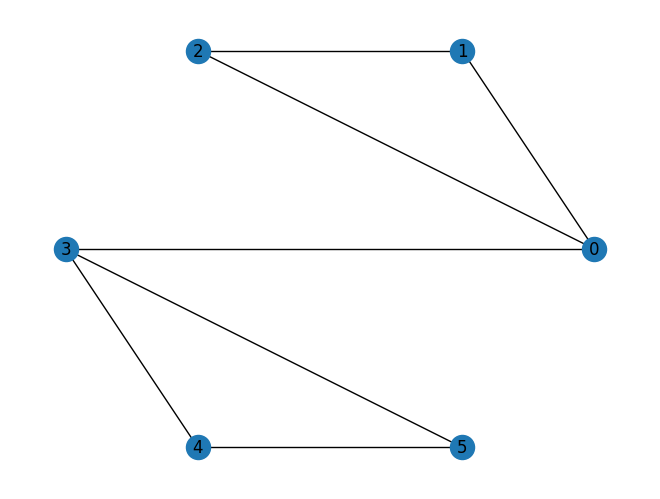

In [3]:
nx.draw_circular(g , with_labels=True)
plt.show()

In [4]:
G = QGraph(g)

/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_57800/1234351715.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  g_adj = nx.adjacency_matrix(g).toarray() # todense()
/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_57800/1234351715.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_comp = nx.adjacency_matrix(G, nodelist=None, dtype=None, weight='weight')


In [ ]:
G.n_qubits

In [5]:
import torch
def bin_int_to_list(a, n_bits):
    import numpy as numpy_np
    a = int(a)
    a_list = [int(i) for i in f'{a:0{n_bits}b}']
    # a_list.reverse()
    return numpy_np.array(a_list)

def nums_to_bin_tensor(num_list, n_data, torch_device='cpu'):
    bin_list_list = np.array([bin_int_to_list(n, n_data) for n in num_list])
    tens_list = torch.tensor(bin_list_list, dtype=torch.float32)
    return tens_list.to(torch_device)

X = nums_to_bin_tensor(range(G.adj.shape[0]), G.n_qubits, torch_device="cpu")
Y = torch.tensor(G.adj, dtype=torch.float32)

In [ ]:
X

In [ ]:
Y

In [6]:
import pennylane as qml

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)
# NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]



In [7]:
import numpy as nnp
import pennylane as qml

class qgraph_model(torch.nn.Module):

    def __init__(self, n_qubits: int, 
                 n_layers: int, 
                 rot: str ='Ry', 
                 shots: int = 0, 
                 scaler: float = nnp.pi):
        """
        Parameters:
        -----------
        n_qubits: int - number of qubits for QNN model
        rot: str      - if 'Ry' - one parameter qubit gate, if 'Rxyz' - three parameters qubit gate
        scaler: float - scaling of data values for example to radians 
        n_layers: int - 
        shots: int    - number of shots if needed
        """
        super(qgraph_model, self).__init__()
        self.n_qubits = n_qubits
        self.rot      = rot
        self.scaler   = scaler
        self.n_layers = n_layers
        self.shots    = shots

        self.layers = torch.nn.Sequential(
            self.quantum_layer(),
        )

    def forward(self, x):
        return  self.layers(x)

    def _basis(self):
        def _circ(inputs, weights):
            self._state_preparation_amplitude(inputs)
            self._ansatz(weights)
            return qml.probs(wires=self.n_qubits)
        return _circ
            

    def quantum_layer(self):
        if self.shots == 0:
            dev = qml.device('default.qubit', wires=self.n_qubits)
        else:
            dev = qml.device('default.qubit', wires=self.n_qubits, shots=self.shots)
        qgraph = self._basis()
        qnode = qml.QNode(qgraph, dev, interface='torch')
        weight_shapes = {"weights": (self.n_layers, self.n_qubits)}
        return qml.qnn.TorchLayer(qnode, weight_shapes)
    
    def _state_preparation_binary(self, x):
        """
        prepare state for a row of data in binary ecoding
        """
        qml.BasisState(x, wires=range(self.n_qubits))

    def _state_preparation_angle(self, x):
        """
        prepare state for a row of scaled data in angle ecoding
        """
        scaled_inputs = torch.mul(x, self.scaler)
        qml.AngleEmbedding(scaled_inputs, wires=self.n_qubits)

    def _state_preparation_amplitude(self, x):
        """
        prepare state for row a data in angle ecoding
        """
        scaled_inputs = torch.mul(x, self.scaler)
        qml.AmplitudeEmbedding(scaled_inputs, wires=range(self.n_qubits))

    def _ansatz(self, weights):
        if self.rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=range(self.n_qubits))
        elif self.rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))

    def get_weights(self):
        return {k:v for k, v in self.state_dict().items() if "weight" in k}

    def get_biases(self):
        return {k:v for k, v in self.state_dict().items() if "bias" in k}

In [8]:
m = qgraph_model(3,1, rot="Rxyz")

In [20]:
np.array([m.get_weights()['layers.0.weights']]).shape

(1, 1, 3)

In [10]:
m.state_dict()

OrderedDict([('layers.0.weights', tensor([[2.8001, 2.7653, 2.5429]]))])

In [ ]:
m._ansatz(m.get_weights()['layers.0.weights'])

IndexError: tuple index out of range